In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage
import imgaug
import imgaug.augmenters as iaa

from tqdm import tqdm


# Root directory of the project
ROOT_DIR = os.path.abspath("./")

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from moles_large import MolesConfig
from moles_large import ISIC17Dataset
from moles_large import ISIC17AugDataset

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lunet/couj/anaconda3/envs/tf/lib/python3

In [2]:
config = MolesConfig()

In [3]:
dataset_train = ISIC17AugDataset()
dataset_train.load_moles("data/large/train/")

#dataset_train = ISIC17Dataset()
#dataset_train.load_moles("data/large/train_o/")

dataset_train.prepare()
ds = dataset_train

dataset_val = ISIC17AugDataset()
dataset_val.load_moles("data/large/val")
dataset_val.prepare()

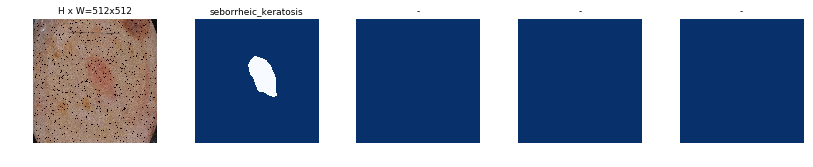

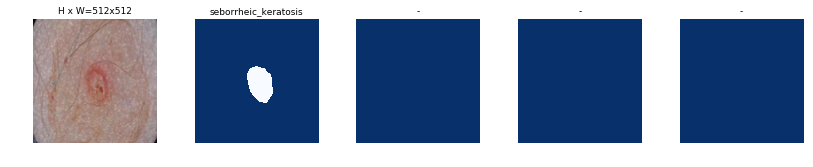

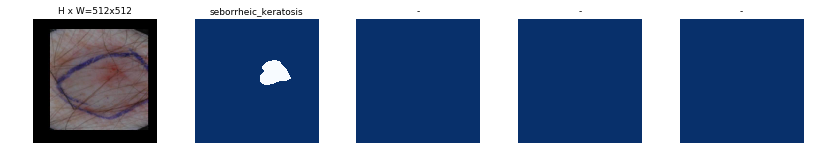

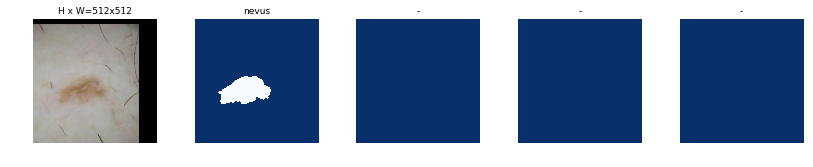

In [4]:
ds = dataset_train

# Load and display random samples
image_ids = np.random.choice(ds.image_ids, 4)
for image_id in image_ids:
    image = ds.load_image(image_id)
    mask, class_ids = ds.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, ds.class_names)

In [5]:
augmentation = iaa.SomeOf((2,5), [
    iaa.Fliplr(1.0),
    iaa.OneOf([
        iaa.GaussianBlur((1, 6.0)),
        iaa.AverageBlur(k=(1, 3)),
        iaa.MedianBlur(k=(3, 5)),
    ]),
    iaa.Flipud(1.0),
    iaa.Rot90((1,3)),
    iaa.CropAndPad(percent=(-0.25, 0.25)),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.2),
    iaa.OneOf([iaa.Dropout((0.01, 0.1), per_channel=0.5),
               iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),]),
    iaa.PiecewiseAffine(scale=(0.01, 0.05)),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.Add((-10, 10), per_channel=0.5),
    iaa.Grayscale(alpha=(0.0, 1.0)),
    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
], random_order=True)

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [7]:
COCO_MODEL_PATH = ROOT_DIR + "/mrcnn/mask_rcnn_coco.h5"
LATEST_MODEL_PATH = ROOT_DIR + "/logs/moles11/mask_rcnn_moles_0337.h5"

LATEST = True

if LATEST:
    model.load_weights(LATEST_MODEL_PATH, by_name=True)
else:
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])


model.keras_model.metrics_tensors = []

In [8]:
# Train top layers
model.train(ds, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads',
            augmentation=augmentation
            )


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200816T0127/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
400/400 [==============================] - 315s 786ms/step - loss: 0.5718 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.1514 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.2140 - val_loss: 0.7810 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.2118 - val_mrcnn_class_loss: 0.1814 - val_mrcnn_bbox_loss: 0.1029 - val_mrcnn_mask_loss: 0.2791
Epoch 2/30
400/400 [==============================] - 255s 639ms/step - loss: 0.5629 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.2146 - val_loss: 1.1563 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.1732 - val_mrcnn_class_loss: 0.4076 - val_mrcnn_bbox_loss: 0.2352 - val_mrcnn_mask_loss: 0.3354
Epoch 3/30
400/400 [==============================] - 294s 734ms/step - loss: 0.6004 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.1492 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.2207 - val_loss: 0.7132 - val_rp

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 248s 619ms/step - loss: 0.5256 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.1311 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.2024 - val_loss: 0.6364 - val_rpn_class_loss: 0.0028 - val_rpn_bbox_loss: 0.0906 - val_mrcnn_class_loss: 0.2887 - val_mrcnn_bbox_loss: 0.0913 - val_mrcnn_mask_loss: 0.1630
Epoch 18/30
400/400 [==============================] - 247s 618ms/step - loss: 0.5507 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.2029 - val_loss: 0.7529 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.1865 - val_mrcnn_class_loss: 0.1355 - val_mrcnn_bbox_loss: 0.1900 - val_mrcnn_mask_loss: 0.2368
Epoch 19/30
400/400 [==============================] - 242s 606ms/step - loss: 0.5177 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1990 - val_loss: 0.8181 - val_rpn_class_l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
# Train middle + top
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE/3,
            epochs=60,
            augmentation=augmentation,
            layers="3+")


Starting at epoch 30. LR=0.0003333333333333333

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200816T0127/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
res3a_branch2c         (Conv2D)
res3a_branch1          (Conv2D)
bn3a_branch2c          (BatchNorm)
bn3a_branch1           (BatchNorm)
res3b_branch2a         (Conv2D)
bn3b_branch2a          (BatchNorm)
res3b_branch2b         (Conv2D)
bn3b_branch2b          (BatchNorm)
res3b_branch2c         (Conv2D)
bn3b_branch2c          (BatchNorm)
res3c_branch2a         (Conv2D)
bn3c_branch2a          (BatchNorm)
res3c_branch2b         (Conv2D)
bn3c_branch2b          (BatchNorm)
res3c_branch2c         (Conv2D)
bn3c_branch2c          (BatchNorm)
res3d_branch2a         (Conv2D)
bn3d_branch2a          (BatchNorm)
res3d_branch2b         (Conv2D)
bn3d_branch2b          (BatchNorm)
res3d_b

Epoch 33/60
400/400 [==============================] - 246s 615ms/step - loss: 0.4413 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1973 - val_loss: 0.5954 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.1358 - val_mrcnn_class_loss: 0.1120 - val_mrcnn_bbox_loss: 0.1177 - val_mrcnn_mask_loss: 0.2277
Epoch 34/60
400/400 [==============================] - 247s 618ms/step - loss: 0.4544 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1989 - val_loss: 0.6739 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.1145 - val_mrcnn_class_loss: 0.1892 - val_mrcnn_bbox_loss: 0.1221 - val_mrcnn_mask_loss: 0.2468
Epoch 35/60
400/400 [==============================] - 252s 630ms/step - loss: 0.4334 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1971 - val_loss: 1.0298 - val

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 239s 597ms/step - loss: 0.3988 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1895 - val_loss: 1.1555 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.1738 - val_mrcnn_class_loss: 0.3911 - val_mrcnn_bbox_loss: 0.2425 - val_mrcnn_mask_loss: 0.3454
Epoch 45/60
400/400 [==============================] - 234s 584ms/step - loss: 0.4156 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1934 - val_loss: 1.0046 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.1775 - val_mrcnn_class_loss: 0.3100 - val_mrcnn_bbox_loss: 0.1950 - val_mrcnn_mask_loss: 0.3192
Epoch 46/60
400/400 [==============================] - 237s 593ms/step - loss: 0.4157 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1995 - val_loss: 0.8696 - val_rpn_class_l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 248s 621ms/step - loss: 0.3639 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1824 - val_loss: 1.2456 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.1667 - val_mrcnn_class_loss: 0.2867 - val_mrcnn_bbox_loss: 0.2760 - val_mrcnn_mask_loss: 0.5141
Epoch 57/60
400/400 [==============================] - 237s 592ms/step - loss: 0.3839 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1883 - val_loss: 1.0214 - val_rpn_class_loss: 0.0041 - val_rpn_bbox_loss: 0.1765 - val_mrcnn_class_loss: 0.3252 - val_mrcnn_bbox_loss: 0.1726 - val_mrcnn_mask_loss: 0.3430
Epoch 58/60
400/400 [==============================] - 248s 620ms/step - loss: 0.3929 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1908 - val_loss: 0.8689 - val_rpn_class_l

In [10]:
# Train middle + top
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE/3,
            epochs=90,
            augmentation=augmentation,
            layers="4+")


Starting at epoch 60. LR=0.0003333333333333333

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200816T0127/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_b

400/400 [==============================] - 251s 628ms/step - loss: 0.3660 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1812 - val_loss: 0.5443 - val_rpn_class_loss: 7.4275e-04 - val_rpn_bbox_loss: 0.0728 - val_mrcnn_class_loss: 0.1617 - val_mrcnn_bbox_loss: 0.0826 - val_mrcnn_mask_loss: 0.2265
Epoch 66/90
400/400 [==============================] - 249s 621ms/step - loss: 0.3622 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1806 - val_loss: 1.1179 - val_rpn_class_loss: 0.0110 - val_rpn_bbox_loss: 0.3188 - val_mrcnn_class_loss: 0.2249 - val_mrcnn_bbox_loss: 0.2314 - val_mrcnn_mask_loss: 0.3317
Epoch 67/90
349/400 [=========================>....] - ETA: 31s - loss: 0.3661 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1842

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 246s 614ms/step - loss: 0.3467 - rpn_class_loss: 9.9700e-04 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1855 - val_loss: 0.8991 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.1092 - val_mrcnn_class_loss: 0.2323 - val_mrcnn_bbox_loss: 0.1896 - val_mrcnn_mask_loss: 0.3652
Epoch 73/90
400/400 [==============================] - 261s 651ms/step - loss: 0.3575 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1828 - val_loss: 1.3080 - val_rpn_class_loss: 0.0056 - val_rpn_bbox_loss: 0.2941 - val_mrcnn_class_loss: 0.3122 - val_mrcnn_bbox_loss: 0.2267 - val_mrcnn_mask_loss: 0.4694
Epoch 74/90
400/400 [==============================] - 257s 641ms/step - loss: 0.3742 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1823 - val_loss: 0.6221 - val_rpn_cla

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 234s 584ms/step - loss: 0.3641 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1855 - val_loss: 0.7697 - val_rpn_class_loss: 0.0069 - val_rpn_bbox_loss: 0.1734 - val_mrcnn_class_loss: 0.1365 - val_mrcnn_bbox_loss: 0.1434 - val_mrcnn_mask_loss: 0.3095
Epoch 84/90
400/400 [==============================] - 248s 619ms/step - loss: 0.3551 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1842 - val_loss: 0.6000 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.0621 - val_mrcnn_class_loss: 0.1957 - val_mrcnn_bbox_loss: 0.1217 - val_mrcnn_mask_loss: 0.2193
Epoch 85/90
400/400 [==============================] - 253s 633ms/step - loss: 0.3372 - rpn_class_loss: 9.5641e-04 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1804 - val_loss: 0.7136 - val_rpn_cla

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Train all
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE/10,
            epochs=200,
            augmentation=augmentation,
            layers="all")


Starting at epoch 90. LR=0.0001

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200816T0127/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

400/400 [==============================] - 299s 748ms/step - loss: 0.3209 - rpn_class_loss: 8.8870e-04 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.1767 - val_loss: 0.9109 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 0.1697 - val_mrcnn_class_loss: 0.1859 - val_mrcnn_bbox_loss: 0.1542 - val_mrcnn_mask_loss: 0.3943
Epoch 92/200
400/400 [==============================] - 247s 617ms/step - loss: 0.3067 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1706 - val_loss: 0.9261 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.1931 - val_mrcnn_class_loss: 0.1440 - val_mrcnn_bbox_loss: 0.1982 - val_mrcnn_mask_loss: 0.3816
Epoch 93/200
400/400 [==============================] - 244s 609ms/step - loss: 0.3195 - rpn_class_loss: 8.8928e-04 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1719 - val_loss: 1.0586 - val_r

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 252s 630ms/step - loss: 0.3112 - rpn_class_loss: 9.9232e-04 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.1755 - val_loss: 0.8295 - val_rpn_class_loss: 0.0118 - val_rpn_bbox_loss: 0.2228 - val_mrcnn_class_loss: 0.1306 - val_mrcnn_bbox_loss: 0.1489 - val_mrcnn_mask_loss: 0.3153
Epoch 103/200
400/400 [==============================] - 256s 641ms/step - loss: 0.3105 - rpn_class_loss: 8.3522e-04 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1717 - val_loss: 0.9449 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.0976 - val_mrcnn_class_loss: 0.3621 - val_mrcnn_bbox_loss: 0.1250 - val_mrcnn_mask_loss: 0.3585
Epoch 104/200
400/400 [==============================] - 244s 609ms/step - loss: 0.3013 - rpn_class_loss: 7.3834e-04 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1698 - val_loss: 1.1441 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 243s 607ms/step - loss: 0.2971 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1642 - val_loss: 0.9943 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.1524 - val_mrcnn_class_loss: 0.2833 - val_mrcnn_bbox_loss: 0.2075 - val_mrcnn_mask_loss: 0.3475
Epoch 113/200
400/400 [==============================] - 243s 608ms/step - loss: 0.2945 - rpn_class_loss: 7.4449e-04 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1685 - val_loss: 1.5545 - val_rpn_class_loss: 0.0081 - val_rpn_bbox_loss: 0.2399 - val_mrcnn_class_loss: 0.5755 - val_mrcnn_bbox_loss: 0.2512 - val_mrcnn_mask_loss: 0.4798
Epoch 114/200
400/400 [==============================] - 247s 618ms/step - loss: 0.3181 - rpn_class_loss: 9.8271e-04 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1695 - val_loss: 0.7413 - val

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 251s 628ms/step - loss: 0.2859 - rpn_class_loss: 8.2294e-04 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1622 - val_loss: 1.1513 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.1375 - val_mrcnn_class_loss: 0.3681 - val_mrcnn_bbox_loss: 0.2420 - val_mrcnn_mask_loss: 0.4019
Epoch 126/200
400/400 [==============================] - 245s 613ms/step - loss: 0.3074 - rpn_class_loss: 9.2296e-04 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1732 - val_loss: 0.9581 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.1565 - val_mrcnn_class_loss: 0.3031 - val_mrcnn_bbox_loss: 0.1608 - val_mrcnn_mask_loss: 0.3366
Epoch 127/200
400/400 [==============================] - 249s 623ms/step - loss: 0.3164 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1737 - val_loss: 0.7759 - val

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 244s 610ms/step - loss: 0.2882 - rpn_class_loss: 8.1444e-04 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1641 - val_loss: 0.6629 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.0622 - val_mrcnn_class_loss: 0.2037 - val_mrcnn_bbox_loss: 0.1245 - val_mrcnn_mask_loss: 0.2704
Epoch 136/200
400/400 [==============================] - 248s 620ms/step - loss: 0.2966 - rpn_class_loss: 8.4097e-04 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1707 - val_loss: 1.5117 - val_rpn_class_loss: 0.0057 - val_rpn_bbox_loss: 0.1794 - val_mrcnn_class_loss: 0.5394 - val_mrcnn_bbox_loss: 0.2271 - val_mrcnn_mask_loss: 0.5601
Epoch 137/200
400/400 [==============================] - 247s 618ms/step - loss: 0.2949 - rpn_class_loss: 8.1027e-04 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1682 - val_loss: 1.0204 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 245s 612ms/step - loss: 0.2997 - rpn_class_loss: 9.5188e-04 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.1703 - val_loss: 0.8543 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.1699 - val_mrcnn_class_loss: 0.2431 - val_mrcnn_bbox_loss: 0.1341 - val_mrcnn_mask_loss: 0.3023
Epoch 147/200
400/400 [==============================] - 243s 607ms/step - loss: 0.2851 - rpn_class_loss: 7.7691e-04 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1646 - val_loss: 1.3415 - val_rpn_class_loss: 0.0069 - val_rpn_bbox_loss: 0.2006 - val_mrcnn_class_loss: 0.3728 - val_mrcnn_bbox_loss: 0.2676 - val_mrcnn_mask_loss: 0.4936
Epoch 148/200
400/400 [==============================] - 244s 609ms/step - loss: 0.2767 - rpn_class_loss: 5.6681e-04 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1629 - val_loss: 1.9385 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 243s 608ms/step - loss: 0.2784 - rpn_class_loss: 8.4035e-04 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.1663 - val_loss: 0.6958 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.2296 - val_mrcnn_class_loss: 0.1032 - val_mrcnn_bbox_loss: 0.0957 - val_mrcnn_mask_loss: 0.2613
Epoch 159/200
400/400 [==============================] - 243s 607ms/step - loss: 0.2828 - rpn_class_loss: 7.1065e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1704 - val_loss: 1.1646 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.1695 - val_mrcnn_class_loss: 0.3788 - val_mrcnn_bbox_loss: 0.1942 - val_mrcnn_mask_loss: 0.4130
Epoch 160/200
400/400 [==============================] - 246s 614ms/step - loss: 0.2878 - rpn_class_loss: 7.2955e-04 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1666 - val_loss: 0.9030 -

In [ ]:
# Train on larger images

In [10]:
# Train top layers
model.train(ds, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=350, 
            layers='heads',
            augmentation=augmentation
            )


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200810T1408/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


KeyboardInterrupt: 

In [7]:
# Train middle + top
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE/3,
            epochs=230,
            augmentation=augmentation,
            layers="4+") 


Starting at epoch 170. LR=0.0003333333333333333

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200729T1201/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 171/230
400/400 [==============================] - 775s 2s/step - loss: 0.5663 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.2222 - val_loss: 0.6583 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.1512 - val_mrcnn_class_loss: 0.1272 - val_mrcnn_bbox_loss: 0.1309 - val_mrcnn_mask_loss: 0.2475
Epoch 172/230
400/400 [==============================] - 693s 2s/step - loss: 0.5204 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.2208 - val_loss: 0.3713 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.0623 - val_mrcnn_class_loss: 0.0879 - val_mrcnn_bbox_loss: 0.0571 - val_mrcnn_mask_loss: 0.1627
Epoch 173/230
400/400 [==============================] - 743s 2s/step - loss: 0.4979 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.2182 - val_loss: 0.4077 - val_rp

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 673s 2s/step - loss: 0.4343 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.2095 - val_loss: 0.4985 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.0977 - val_mrcnn_class_loss: 0.1415 - val_mrcnn_bbox_loss: 0.0821 - val_mrcnn_mask_loss: 0.1761
Epoch 189/230
400/400 [==============================] - 667s 2s/step - loss: 0.4246 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.2090 - val_loss: 0.4135 - val_rpn_class_loss: 0.0010 - val_rpn_bbox_loss: 0.1100 - val_mrcnn_class_loss: 0.0798 - val_mrcnn_bbox_loss: 0.0648 - val_mrcnn_mask_loss: 0.1579
Epoch 190/230
400/400 [==============================] - 661s 2s/step - loss: 0.4249 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.2054 - val_loss: 0.7190 - val_rpn_class_loss: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 665s 2s/step - loss: 0.4048 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.2036 - val_loss: 0.5406 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.0779 - val_mrcnn_class_loss: 0.2230 - val_mrcnn_bbox_loss: 0.0662 - val_mrcnn_mask_loss: 0.1710
Epoch 205/230
400/400 [==============================] - 673s 2s/step - loss: 0.4021 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1965 - val_loss: 0.4811 - val_rpn_class_loss: 4.1581e-04 - val_rpn_bbox_loss: 0.0377 - val_mrcnn_class_loss: 0.1523 - val_mrcnn_bbox_loss: 0.0905 - val_mrcnn_mask_loss: 0.2001
Epoch 206/230
400/400 [==============================] - 665s 2s/step - loss: 0.3781 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1957 - val_loss: 0.2871 - val_rpn_class_lo

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 668s 2s/step - loss: 0.3573 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1908 - val_loss: 0.4234 - val_rpn_class_loss: 9.6309e-04 - val_rpn_bbox_loss: 0.0556 - val_mrcnn_class_loss: 0.0966 - val_mrcnn_bbox_loss: 0.0950 - val_mrcnn_mask_loss: 0.1752
Epoch 222/230
400/400 [==============================] - 666s 2s/step - loss: 0.3971 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1914 - val_loss: 0.3847 - val_rpn_class_loss: 6.7751e-04 - val_rpn_bbox_loss: 0.0665 - val_mrcnn_class_loss: 0.0834 - val_mrcnn_bbox_loss: 0.0805 - val_mrcnn_mask_loss: 0.1536
Epoch 223/230
400/400 [==============================] - 662s 2s/step - loss: 0.3393 - rpn_class_loss: 8.6425e-04 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1863 - val_loss: 0.4782 - val_rpn_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
# Train all
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=700,
            augmentation=augmentation,
            layers="all")


Starting at epoch 600. LR=0.0001

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200729T1201/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 255s 638ms/step - loss: 0.2524 - rpn_class_loss: 8.6202e-04 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1480 - val_loss: 0.6395 - val_rpn_class_loss: 0.0063 - val_rpn_bbox_loss: 0.0864 - val_mrcnn_class_loss: 0.2039 - val_mrcnn_bbox_loss: 0.0996 - val_mrcnn_mask_loss: 0.2434
Epoch 618/700
400/400 [==============================] - 243s 608ms/step - loss: 0.2384 - rpn_class_loss: 6.2136e-04 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.1496 - val_loss: 0.3721 - val_rpn_class_loss: 8.5100e-05 - val_rpn_bbox_loss: 0.0419 - val_mrcnn_class_loss: 0.0745 - val_mrcnn_bbox_loss: 0.0438 - val_mrcnn_mask_loss: 0.2118
Epoch 619/700
400/400 [==============================] - 252s 631ms/step - loss: 0.2440 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1479 - val_loss: 0.6109 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 257s 642ms/step - loss: 0.2372 - rpn_class_loss: 7.2248e-04 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.1481 - val_loss: 0.5825 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 0.0952 - val_mrcnn_class_loss: 0.1338 - val_mrcnn_bbox_loss: 0.0946 - val_mrcnn_mask_loss: 0.2577
Epoch 635/700
400/400 [==============================] - 263s 658ms/step - loss: 0.2423 - rpn_class_loss: 8.3616e-04 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1513 - val_loss: 0.5461 - val_rpn_class_loss: 5.3513e-04 - val_rpn_bbox_loss: 0.0445 - val_mrcnn_class_loss: 0.0572 - val_mrcnn_bbox_loss: 0.1082 - val_mrcnn_mask_loss: 0.3356
Epoch 636/700
400/400 [==============================] - 253s 632ms/step - loss: 0.2486 - rpn_class_loss: 6.1221e-04 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1539 - val_loss: 0.49

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 242s 606ms/step - loss: 0.2399 - rpn_class_loss: 4.9794e-04 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1500 - val_loss: 0.4733 - val_rpn_class_loss: 1.6556e-04 - val_rpn_bbox_loss: 0.0915 - val_mrcnn_class_loss: 0.0315 - val_mrcnn_bbox_loss: 0.0918 - val_mrcnn_mask_loss: 0.2583
Epoch 651/700
400/400 [==============================] - 248s 620ms/step - loss: 0.2273 - rpn_class_loss: 6.8470e-04 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1455 - val_loss: 0.2839 - val_rpn_class_loss: 1.0121e-04 - val_rpn_bbox_loss: 0.0333 - val_mrcnn_class_loss: 0.0722 - val_mrcnn_bbox_loss: 0.0309 - val_mrcnn_mask_loss: 0.1474
Epoch 652/700
400/400 [==============================] - 256s 641ms/step - loss: 0.2273 - rpn_class_loss: 6.2329e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1438 - val_loss: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 243s 607ms/step - loss: 0.2534 - rpn_class_loss: 9.6525e-04 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1514 - val_loss: 0.3599 - val_rpn_class_loss: 5.4719e-04 - val_rpn_bbox_loss: 0.0443 - val_mrcnn_class_loss: 0.0678 - val_mrcnn_bbox_loss: 0.0553 - val_mrcnn_mask_loss: 0.1920
Epoch 668/700
400/400 [==============================] - 248s 619ms/step - loss: 0.2318 - rpn_class_loss: 6.8591e-04 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.1443 - val_loss: 0.5168 - val_rpn_class_loss: 1.8596e-04 - val_rpn_bbox_loss: 0.0638 - val_mrcnn_class_loss: 0.1350 - val_mrcnn_bbox_loss: 0.0692 - val_mrcnn_mask_loss: 0.2486
Epoch 669/700
400/400 [==============================] - 253s 631ms/step - loss: 0.2373 - rpn_class_loss: 6.1211e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.1501 - val_loss: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 257s 642ms/step - loss: 0.2393 - rpn_class_loss: 6.2076e-04 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.1510 - val_loss: 0.5670 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.0583 - val_mrcnn_class_loss: 0.1106 - val_mrcnn_bbox_loss: 0.1330 - val_mrcnn_mask_loss: 0.2616
Epoch 684/700
400/400 [==============================] - 247s 617ms/step - loss: 0.2421 - rpn_class_loss: 4.4933e-04 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.1533 - val_loss: 0.7342 - val_rpn_class_loss: 0.0020 - val_rpn_bbox_loss: 0.2146 - val_mrcnn_class_loss: 0.1065 - val_mrcnn_bbox_loss: 0.0980 - val_mrcnn_mask_loss: 0.3131
Epoch 685/700
400/400 [==============================] - 257s 642ms/step - loss: 0.2467 - rpn_class_loss: 8.4529e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.1493 - val_loss: 0.7727 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 249s 622ms/step - loss: 0.2370 - rpn_class_loss: 6.0089e-04 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1476 - val_loss: 0.4916 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.0425 - val_mrcnn_class_loss: 0.1113 - val_mrcnn_bbox_loss: 0.0752 - val_mrcnn_mask_loss: 0.2581
Epoch 700/700
400/400 [==============================] - 264s 659ms/step - loss: 0.2381 - rpn_class_loss: 7.8191e-04 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1459 - val_loss: 0.4566 - val_rpn_class_loss: 1.7214e-04 - val_rpn_bbox_loss: 0.0523 - val_mrcnn_class_loss: 0.1539 - val_mrcnn_bbox_loss: 0.0553 - val_mrcnn_mask_loss: 0.1950


In [ ]:
# Train top layers
model.train(ds, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=750, 
            layers='heads',
            augmentation=augmentation
            )


Starting at epoch 700. LR=0.001

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200729T1201/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 701/750
400/400 [==============================] - 291s 728ms/step - loss: 0.3489 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1699 - val_loss: 1.1642 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.4225 - val_mrcnn_class_loss: 0.1048 - val_mrcnn_bbox_loss: 0.1944 - val_mrcnn_mask_loss: 0.4322
Epoch 702/750
400/400 [==============================] - 242s 606ms/step - loss: 0.3570 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1698 - val_loss: 1.0832 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 0.2375 - val_mrcnn_class_loss: 0.2757 - val_mrcnn_bbox_loss: 0.2425 - val_mrcnn_mask_loss: 0.3238
Epoch 703/750
400/400 [==============================] - 272s 681ms/step - loss: 0.3358 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1652 - val_loss: 1.1296

In [7]:
# Train middle + top
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE/3,
            epochs=850,
            augmentation=augmentation,
            layers="4+") 


Starting at epoch 800. LR=0.0003333333333333333

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200729T1201/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_

/home/lunet/couj/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 801/850
400/400 [==============================] - 304s 760ms/step - loss: 0.2684 - rpn_class_loss: 9.6270e-04 - rpn_bbox_loss: 0.0467 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1516 - val_loss: 0.6368 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.0643 - val_mrcnn_class_loss: 0.2199 - val_mrcnn_bbox_loss: 0.0976 - val_mrcnn_mask_loss: 0.2528
Epoch 802/850
400/400 [==============================] - 238s 595ms/step - loss: 0.2667 - rpn_class_loss: 5.9642e-04 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.1539 - val_loss: 1.1530 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.1193 - val_mrcnn_class_loss: 0.4683 - val_mrcnn_bbox_loss: 0.1667 - val_mrcnn_mask_loss: 0.3971
Epoch 803/850
400/400 [==============================] - 280s 701ms/step - loss: 0.2502 - rpn_class_loss: 7.6922e-04 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1497 - val_

400/400 [==============================] - 254s 635ms/step - loss: 0.2416 - rpn_class_loss: 6.0418e-04 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.1518 - val_loss: 1.0791 - val_rpn_class_loss: 0.0241 - val_rpn_bbox_loss: 0.6000 - val_mrcnn_class_loss: 0.0755 - val_mrcnn_bbox_loss: 0.1220 - val_mrcnn_mask_loss: 0.2576
Epoch 844/850
400/400 [==============================] - 253s 631ms/step - loss: 0.2463 - rpn_class_loss: 6.5017e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1521 - val_loss: 1.3252 - val_rpn_class_loss: 0.0104 - val_rpn_bbox_loss: 0.2232 - val_mrcnn_class_loss: 0.1734 - val_mrcnn_bbox_loss: 0.2618 - val_mrcnn_mask_loss: 0.6563
Epoch 845/850
400/400 [==============================] - 246s 616ms/step - loss: 0.2488 - rpn_class_loss: 6.4951e-04 - rpn_bbox_loss: 0.0360 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1490 - val_loss: 0.9706 -

In [ ]:
# Train all
model.train(ds, dataset_val,
            learning_rate=config.LEARNING_RATE/10,
            epochs=900,
            augmentation=augmentation,
            layers="all")


Starting at epoch 850. LR=0.0001

Checkpoint Path: /home/lunet/couj/project/lesion-detection/logs/moles20200729T1201/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

400/400 [==============================] - 281s 703ms/step - loss: 0.2287 - rpn_class_loss: 6.4713e-04 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1413 - val_loss: 1.5074 - val_rpn_class_loss: 0.0267 - val_rpn_bbox_loss: 0.7494 - val_mrcnn_class_loss: 0.2072 - val_mrcnn_bbox_loss: 0.1478 - val_mrcnn_mask_loss: 0.3763
Epoch 852/900
400/400 [==============================] - 242s 604ms/step - loss: 0.2162 - rpn_class_loss: 5.7054e-04 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1408 - val_loss: 0.6657 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.1592 - val_mrcnn_class_loss: 0.1201 - val_mrcnn_bbox_loss: 0.1248 - val_mrcnn_mask_loss: 0.2603
Epoch 853/900
400/400 [==============================] - 244s 611ms/step - loss: 0.2345 - rpn_class_loss: 8.8853e-04 - rpn_bbox_loss: 0.0385 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1436 - val_loss: 0.5399 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 246s 615ms/step - loss: 0.2135 - rpn_class_loss: 4.4964e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.1391 - val_loss: 0.5306 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.0849 - val_mrcnn_class_loss: 0.1072 - val_mrcnn_bbox_loss: 0.0907 - val_mrcnn_mask_loss: 0.2464
Epoch 864/900
400/400 [==============================] - 248s 619ms/step - loss: 0.2247 - rpn_class_loss: 7.1847e-04 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1403 - val_loss: 1.7634 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 0.2453 - val_mrcnn_class_loss: 0.5549 - val_mrcnn_bbox_loss: 0.3440 - val_mrcnn_mask_loss: 0.6118
Epoch 865/900
400/400 [==============================] - 260s 650ms/step - loss: 0.2233 - rpn_class_loss: 6.4407e-04 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.1413 - val_loss: 0.9518 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 242s 604ms/step - loss: 0.2138 - rpn_class_loss: 5.5912e-04 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1398 - val_loss: 0.8196 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.1323 - val_mrcnn_class_loss: 0.1737 - val_mrcnn_bbox_loss: 0.1496 - val_mrcnn_mask_loss: 0.3626
Epoch 875/900
400/400 [==============================] - 241s 603ms/step - loss: 0.2162 - rpn_class_loss: 4.3139e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1400 - val_loss: 1.1718 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.1524 - val_mrcnn_class_loss: 0.2475 - val_mrcnn_bbox_loss: 0.2688 - val_mrcnn_mask_loss: 0.4984
Epoch 876/900
400/400 [==============================] - 242s 606ms/step - loss: 0.2135 - rpn_class_loss: 8.0482e-04 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.1349 - val_loss: 0.8105 -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



400/400 [==============================] - 243s 608ms/step - loss: 0.2271 - rpn_class_loss: 6.9905e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1450 - val_loss: 0.7054 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.0625 - val_mrcnn_class_loss: 0.2293 - val_mrcnn_bbox_loss: 0.1190 - val_mrcnn_mask_loss: 0.2929
Epoch 887/900
400/400 [==============================] - 242s 605ms/step - loss: 0.2184 - rpn_class_loss: 5.8087e-04 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.1377 - val_loss: 0.8596 - val_rpn_class_loss: 0.0054 - val_rpn_bbox_loss: 0.2504 - val_mrcnn_class_loss: 0.1373 - val_mrcnn_bbox_loss: 0.1500 - val_mrcnn_mask_loss: 0.3165
Epoch 888/900
400/400 [==============================] - 242s 605ms/step - loss: 0.2188 - rpn_class_loss: 6.3264e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.1389 - val_loss: 0.3852 -